In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
from pathlib import Path
from PIL import Image
import matplotlib.pylab as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms

In [62]:
DATA_ROOT = Path("/content/drive/MyDrive")
TRAIN_PATH=DATA_ROOT/"train"
TEST_PATH=DATA_ROOT/"test"
EVAL_PATH=DATA_ROOT/"eval"

In [63]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu") # Change 1
print(device)

cuda


In [64]:
for folder in TRAIN_PATH.iterdir():
  print(folder.name)

forest
buildings
mountain
street
glacier
sea


In [65]:
train_images=list(TRAIN_PATH.rglob("*.jpg"))
print(f"The total number of train images are:{len(train_images)}")

The total number of train images are:14034


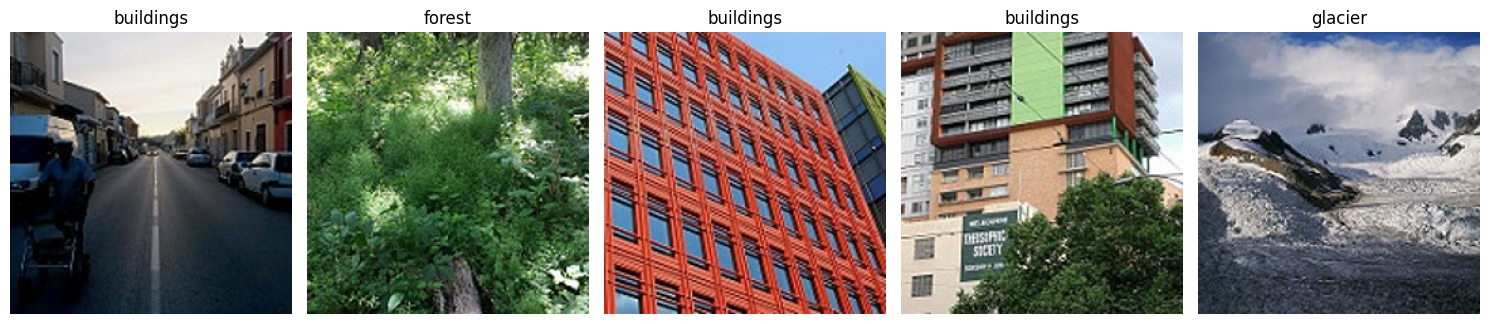

In [66]:
fig,axes=plt.subplots(1,5,figsize=(15,6))

for img in range(5):
  image=random.choice(train_images)
  image_path=image.parent.name
  image=Image.open(image).convert("RGB").resize((224,224))

  axes[img].imshow(image)
  axes[img].set_title(image_path)
  axes[img].axis('off')

plt.tight_layout()
plt.show()

In [67]:
class CustomDataset(Dataset):

  def __init__(self,root_path,transformation):
    super().__init__()
    self.root_path=root_path
    self.transformation=transformation
    self.labels=[]
    self.image_path=[]

    classes=["sea","glacier","forest","street","mountain","buildings"]

    for index,class_name in enumerate(classes):
      class_folder=self.root_path/class_name

      for img in class_folder.iterdir():
        if img.suffix.lower() in [".jpeg",".jpg",".png"]:
          self.image_path.append(img)
          self.labels.append(index)

  def __len__(self):
    return len(self.image_path)

  def __getitem__(self,index):
    image=self.image_path[index]
    label=self.labels[index]

    image=Image.open(image).convert("RGB")

    if self.transformation:
      image=self.transformation(image)

    return image,label

In [68]:
class SimpleModel(nn.Module):

  def __init__(self,num_features,num_classes=6):
    super().__init__()
    self.features=nn.Flatten()
    self.classifier=nn.Linear(num_features,num_classes)

  def forward(self,x):
    output=self.features(x)
    output=self.classifier(output)

    return output

In [69]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

In [70]:
train_data=CustomDataset(TRAIN_PATH,transform)
eval_data=CustomDataset(EVAL_PATH,transform)

In [71]:
train_dataloader=DataLoader(train_data,batch_size=64,shuffle=True)
eval_dataloader=DataLoader(eval_data,batch_size=64,shuffle=False)

In [72]:
epochs=10
learning_rate=1e-4
loss=nn.CrossEntropyLoss()
model = SimpleModel(num_features=224*224*3, num_classes=6)
model=model.to(device) # Change 2
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

In [73]:
history={'train_loss':[],'train_accuracy':[],'eval_loss':[],'eval_accuracy':[]}

for epoch in range(epochs):
  model.train()
  t_correct,t_loss,t_count=0,0,0
  for batch_feature,batch_label in train_dataloader:
    batch_feature,batch_label=batch_feature.to(device),batch_label.to(device)
    optimizer.zero_grad()
    output=model(batch_feature)
    model_loss=loss(output,batch_label)
    model_loss.backward()
    optimizer.step()

    # Calculate accuracy:
    _,predicted=torch.max(output,1)
    t_count+=batch_feature.shape[0]
    t_correct+=(predicted==batch_label).sum().item()
    t_loss+=model_loss.item()

  model.eval()
  v_correct,v_loss,v_count=0,0,0
  with torch.no_grad():
      for batch_feature,batch_label in eval_dataloader:
        batch_feature,batch_label=batch_feature.to(device),batch_label.to(device)
        output=model(batch_feature)
        model_loss=loss(output,batch_label)

        # Calculate accuracy:
        _,predicted=torch.max(output,1)
        v_count+=batch_feature.shape[0]
        v_correct+=(predicted==batch_label).sum().item()
        v_loss+=model_loss.item()

  history['train_loss'].append(t_loss/len(train_dataloader))
  history['eval_loss'].append(v_loss/len(eval_dataloader))
  history['train_accuracy'].append(t_correct/t_count)
  history['eval_accuracy'].append(v_correct/v_count)

  print(f"Epochs {epoch+1} | Train Accuracy:{history['train_accuracy'][-1]:.2f} | Train Loss:{history['train_loss'][-1]:.2f} | Eval Accuracy:{history['eval_accuracy'][-1]:.2f} | Eval Loss:{history['eval_loss'][-1]:.2f}")

Epochs 1 | Train Accuracy:0.46 | Train Loss:1.63 | Eval Accuracy:0.43 | Eval Loss:1.71
Epochs 2 | Train Accuracy:0.51 | Train Loss:1.44 | Eval Accuracy:0.47 | Eval Loss:1.89
Epochs 3 | Train Accuracy:0.55 | Train Loss:1.30 | Eval Accuracy:0.42 | Eval Loss:1.66
Epochs 4 | Train Accuracy:0.59 | Train Loss:1.18 | Eval Accuracy:0.48 | Eval Loss:1.72
Epochs 5 | Train Accuracy:0.61 | Train Loss:1.14 | Eval Accuracy:0.44 | Eval Loss:1.61
Epochs 6 | Train Accuracy:0.63 | Train Loss:1.06 | Eval Accuracy:0.44 | Eval Loss:2.03
Epochs 7 | Train Accuracy:0.64 | Train Loss:1.04 | Eval Accuracy:0.46 | Eval Loss:1.76
Epochs 8 | Train Accuracy:0.66 | Train Loss:0.98 | Eval Accuracy:0.47 | Eval Loss:1.79
Epochs 9 | Train Accuracy:0.69 | Train Loss:0.91 | Eval Accuracy:0.46 | Eval Loss:1.81
Epochs 10 | Train Accuracy:0.71 | Train Loss:0.84 | Eval Accuracy:0.46 | Eval Loss:1.78


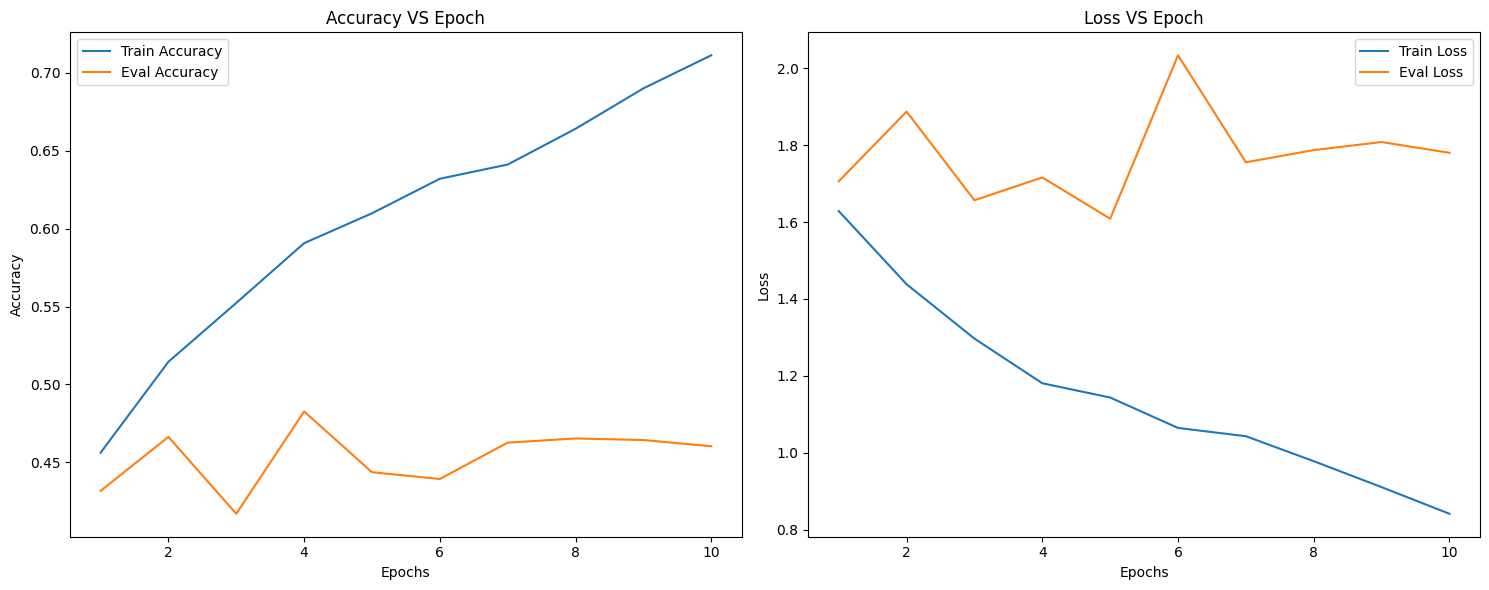

In [78]:
fig,axes=plt.subplots(1,2,figsize=(15,6))

axes[0].plot(range(1,epochs+1),history['train_accuracy'],label="Train Accuracy")
axes[0].plot(range(1,epochs+1),history['eval_accuracy'],label="Eval Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy VS Epoch")
axes[0].legend()

axes[1].plot(range(1,epochs+1),history['train_loss'],label="Train Loss")
axes[1].plot(range(1,epochs+1),history['eval_loss'],label="Eval Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss VS Epoch")
axes[1].legend()

plt.tight_layout()
plt.show()
